## Drifters and Cmems data Notebook

### Introduction
This notebook aims to analyze the velocity data from drifters within the tropical Atlantic Ocean. It involves visualizing drifter velocity data, interpolating CMEMS data onto drifter data, and comparing the velocities between drifters and CMEMS.

### Data Sources
- Drifter Data:
  - Source: NOAA
  - Collection Frequency: Every 6 hours
  - Total Number of Drifters: 127
  - link : https://erddap.aoml.noaa.gov/gdp/erddap/tabledap/drifter_6hour_qc.html
  - Periode : period : 2023-03-30 to 2023-07-09

- CMEMS Data:
  - Source: Copernicus Marine
  - Collection Frequency: Every 12 hours
  - Data Product: SEALEVEL_GLO_PHY_L4_MY_008_047
  - link :  https://doi.org/10.48670/moi-00148
  - download data : ahttps://data.marine.copernicus.eu/product/SEALEVEL_GLO_PHY_L4_MY_008_047/download
  - Periode : period : 2023-03-30 to 2023-07-09

### Tasks

#### 1. Visualization of Drifter Velocity Data
- Plot the Eastward (ve) and Northward (vn) velocity as a function of time for a selected drifter.

#### 2. Interpolation of CMEMS Data on Drifter Data
- Interpolate CMEMS data onto the time series of the selected drifter data.

#### 3. Comparison between Drifter Velocities and Interpolated CMEMS Velocities
- Visualize the correlation and regression between drifter velocities (ve, vn) and interpolated CMEMS between the two datasets.
- Plot time series of both drifter velocities and interpolated CMEMS velocities.

## Import Library


In [1]:
import pandas as pd
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt
from scipy.interpolate import interp2d

import cartopy.crs as ccrs
import cartopy.mpl.ticker as cticker
import cartopy.feature as cfeature
from cartopy import config
import matplotlib.animation
from scipy.stats import linregress
from scipy.stats import pearsonr

## Read Drifter Data


In [2]:
fn='./drifter_6hour_qc_c452_ec74_11dc_U1720711192841.nc';
ds=xr.open_dataset(fn);
np.min(ds.time.values)

numpy.datetime64('2023-03-30T06:00:00.000000000')

## Extract Coordinates and Variables


In [3]:
ve_curr = ds.ve.values
vn_curr = ds.vn.values
sst = ds.sst.values
lon = ds.longitude.values
lat = ds.latitude.values
time = ds.time.values

## Creation of Pandas Array for Drifter Data


In [4]:
data = {
    'longitude': lon,
    'latitude' : lat,
    'time'     : time,
    've'       : ve_curr,
    'vn'       : vn_curr,
    'sst'      : sst
}

df = pd.DataFrame(data)

## Selecting Drifter Data


In [5]:
# Test: Our selected drifter has 613 observations.  

df_1 = df[22657:23061]

# Arrange to begin with index 0

In [6]:
ve_curr_2 = df_1.ve.values
vn_curr_2 = df_1.vn.values
sst_2 = df_1.sst.values
lon_2 = df_1.longitude.values
lat_2 = df_1.latitude.values
time_2 = df_1.time.values

In [7]:
data = {
    'longitude': lon_2,
    'latitude' : lat_2,
    'time'     : time_2,
    've'       : ve_curr_2,
    'vn'       : vn_curr_2,
    'sst'      : sst_2
}

df_2 = pd.DataFrame(data)

## Space evolution of Eastward (ve) and Northward (vn) Velocity 

## Case of ve

The drifter is moving mainly northward.


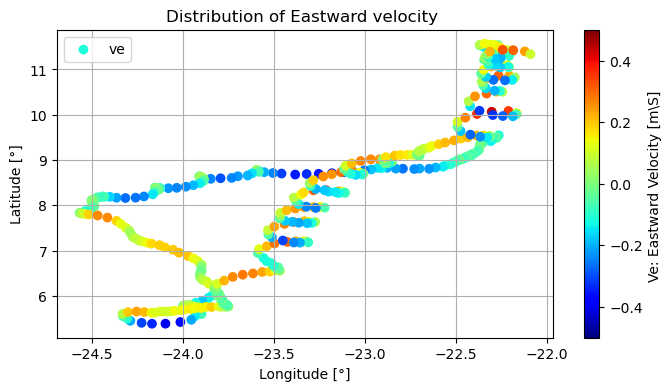

In [8]:
# Assuming you have a DataFrame named df with 'time' and 've' columns
# Plot ve as a function of time
plt.figure(figsize=(8, 4))
plt.scatter(df_2['longitude'], df_2['latitude'], c= df_2['ve'],vmin=-0.5, vmax=0.5, cmap='jet', marker='o')

# Add title, axis labels, grid and legend
plt.title('Distribution of Eastward velocity ')
plt.xlabel('Longitude [°]')
plt.ylabel('Latitude [°]')
plt.grid(True)
plt.colorbar(label='Ve: Eastward Velocity [m\S] ')

# Example of drifter trajectory data (latitude, longitude)
longitude = df_2['longitude']
latitude = df_2['latitude']

# Calculating position changes
delta_lat = np.diff(latitude)
delta_lon = np.diff(longitude)

# Determining the general direction of movement
if np.abs(delta_lat.sum()) > np.abs(delta_lon.sum()):
    if delta_lat.sum() > 0:
        direction = "northward"
    else:
        direction = "southward"
else:
    if delta_lon.sum() > 0:
        direction = "eastward"
    else:
        direction = "westward"

print(f"The drifter is moving mainly {direction}.")        

plt.legend(['ve'])
plt.savefig("fig6 mode.png")
plt.show()

## Case of vn

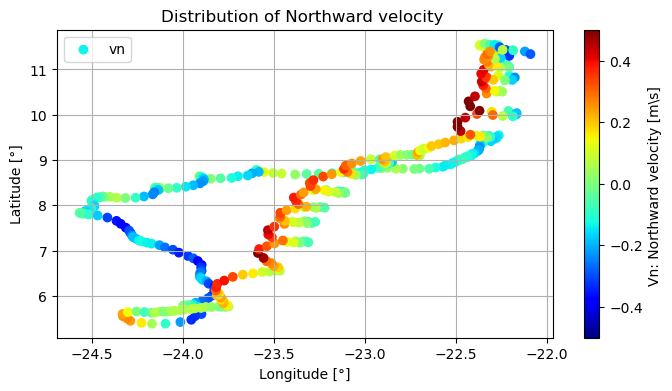

In [9]:
# Assuming you have a DataFrame named df with 'time' and 've' columns
# Plot ve as a function of time
plt.figure(figsize=(8, 4))
plt.scatter(df_2['longitude'], df_2['latitude'], c= df_2['vn'],vmin=-0.5, vmax=0.5, cmap='jet', marker='o')

# Add title, axis labels, grid and legend
plt.title('Distribution of Northward velocity ')
plt.xlabel('Longitude [°]')
plt.ylabel('Latitude [°]')
plt.grid(True)
plt.colorbar(label='Vn: Northward velocity [m\s] ')

plt.legend(['vn'])
plt.savefig("fig7 mode.png")
plt.show()

In [10]:
# Coriolis constant (using the mean latitude in radians)
mean_latitude_radians = np.radians(8)
coriolis_parameter = 2 * 7.2921e-5 * np.sin(mean_latitude_radians)
T =6.28/coriolis_parameter
a = T/3600
a

85.94472525742867

In [11]:
14*6.28

87.92

## Now let's interpolate the CMEMS data onto the grid of the drifter data.

### Case of Geostrophic Velocity Anomalies: Zonal Component (ugosa) 


- In this step, we interpolate the ugosa variable from the CMEMS data to the ve variable of the selected drifter.

- We utilize the linear interpolation method for this process. The interpolation is performed based on the variables of longitude, latitude, and important timestamps.

- This allows us to make comparisons and identify differences between drifter variables and CMEMS variables obtained through interpolations.

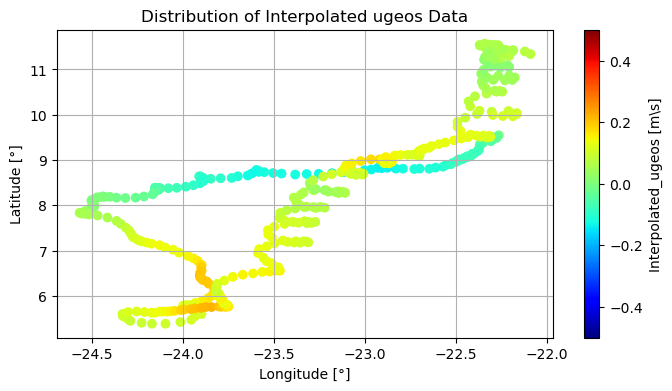

In [12]:
# Chargement des données des bouées dérivantes à partir du DataFrame
df_bouees = df_2  
 
# Chargement des données satellitaires à partir du fichier netCDF
ds_satellitaires = xr.open_dataset('ugos_vgos.nc')   
 
# Extraction des données de courant des bouées
bouees_courant_u = df_bouees['ve']

# Extraction des données de courant satellitaires pour les mêmes positions spatiales et temporelles que les bouées
latitudes = df_bouees['latitude']
longitudes = df_bouees['longitude']
temps = df_bouees['time']

satellitaires_courant_1 = []
for i in range(len(df_bouees)):
    lat = latitudes[i]
    lon = longitudes[i]
    time = temps[i]
    courant = ds_satellitaires['ugos'].interp(latitude=lat, longitude=lon, time=time).values
    satellitaires_courant_1.append(courant)

# Plot the interpolated data
plt.figure(figsize=(8, 4))
plt.scatter(df_2['longitude'], df_2['latitude'], c= satellitaires_courant_1,vmin=-0.5, vmax=0.5, cmap='jet', marker='o')

# Add title, axis labels, grid and colorbar
plt.title('Distribution of Interpolated ugeos Data')
plt.xlabel('Longitude [°]')
plt.ylabel('Latitude [°]')
plt.grid(True)
plt.colorbar(label='Interpolated_ugeos [m\s]')
plt.savefig("fig8 mode.png")
plt.show()

### Case of Geostrophic Velocity Anomalies: Meridional Component (vgosa) 

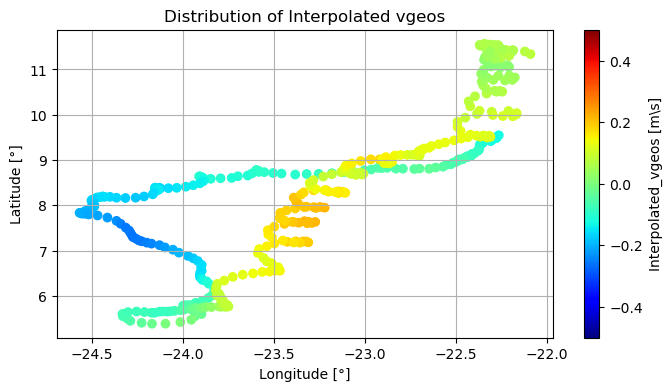

In [13]:
# Chargement des données des bouées dérivantes à partir du DataFrame
df_bouees = df_2
# Supposez que votre DataFrame contient des colonnes 'temps', 'latitude', 'longitude' et 'vn'

# Chargement des données satellitaires à partir du fichier netCDF
ds_satellitaires = xr.open_dataset('ugos_vgos.nc')   
# Supposez que vos données satellitaires sont stockées dans une variable appelée 'u_current'

# Extraction des données de courant des bouées
bouees_courant_v = df_bouees['vn']

# Extraction des données de courant satellitaires pour les mêmes positions spatiales et temporelles que les bouées
latitudes = df_bouees['latitude']
longitudes = df_bouees['longitude']
temps = df_bouees['time']

satellitaires_courant_2 = []
for i in range(len(df_bouees)):
    lat = latitudes[i]
    lon = longitudes[i]
    time = temps[i]
    courant = ds_satellitaires['vgos'].interp(latitude=lat, longitude=lon, time=time).values
    satellitaires_courant_2.append(courant)

# Plot the interpolated data
plt.figure(figsize=(8, 4))
plt.scatter(df_2['longitude'], df_2['latitude'], c= satellitaires_courant_2,vmin=-0.5, vmax=0.5, cmap='jet', marker='o')

# Add title, axis labels, grid and colorbar
plt.title('Distribution of Interpolated vgeos')
plt.xlabel('Longitude [°]')
plt.ylabel('Latitude [°]')
plt.grid(True)
plt.colorbar(label='Interpolated_vgeos [m\s]')
plt.savefig("fig9 mode.png")
plt.show()

## Now Let's Compare Drifter Speeds and  CMEMS Speeds

## Comparison between ve and ugosa


## Using Regression and Correlation

Corrélation de Pearson: 0.4480353029598684
Valeur de p (p-value): 2.425746345943193e-21


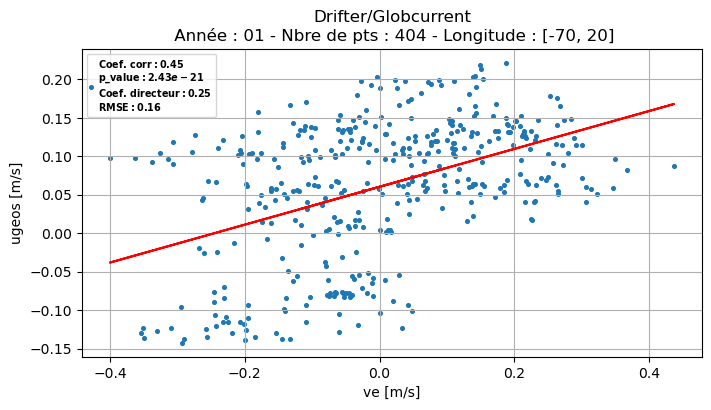

In [14]:
# According to the following, we can simply note that the correlation between "ve" and "ugosa_interpolate" is 0.81. 
# This means that there is a positive and strong relationship  between this two variables.
# Calcul de la corrélation spatiale et temporelle Pearson
correlation, p_value = pearsonr(bouees_courant_u, satellitaires_courant_1)

print("Corrélation de Pearson:", correlation) # R = 0.81
print("Valeur de p (p-value):", p_value)

# Fit linear regression model

slope, intercept, _, _, _ = linregress( bouees_courant_u,satellitaires_courant_1)

# Calcul de la régression linéaire
coefficients = np.polyfit(bouees_courant_u, satellitaires_courant_1, 1)
p = np.poly1d(coefficients) # p = 0.25

# Calcul de l'erreur quadratique moyenne (RMSE)
rmse = np.sqrt(np.mean((bouees_courant_u - satellitaires_courant_1)**2)) # r = 0.16

# Plot data and linear regression line
plt.figure(figsize=(8, 4))
plt.scatter(bouees_courant_u,satellitaires_courant_1, s=7)
plt.plot(bouees_courant_u, slope*bouees_courant_u + intercept, color='red', label='Linear Regression')
plt.xlabel('ve [m/s]')
plt.ylabel('ugeos [m/s]')

# Légende
legend_text = (
    r'$\text{Coef. corr} : 0.45$' + '\n'
    r'$\text{p_value} : 2.43e-21$' + '\n'
    r'$\text{Coef. directeur} : 0.25$' + '\n'
    r'$\text{RMSE} : 0.16$'
)

# Affichage de la légende
plt.legend([legend_text], title='', fontsize='x-small', title_fontsize='x-small', handlelength=0, loc="upper left")

# Titre
title_text = 'Drifter/Globcurrent\n Année : 01 - Nbre de pts : 404 - Longitude : [-70, 20]'
plt.title(title_text, fontsize=12)
plt.grid(True)

# Set font size and font weight for tick labels
plt.rcParams['font.size'] = 12
plt.rcParams['font.weight'] = 'bold'
plt.savefig("fig10 mode.png")
plt.show()

## Using Time Series

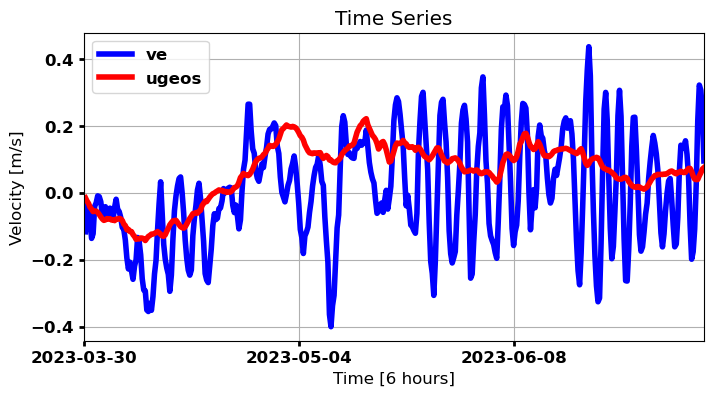

In [15]:
 # Plot time series
plt.figure(figsize=(8, 4))
plt.plot(df_2['time'], bouees_courant_u, color='Blue', label='ve', linewidth=4)
plt.plot(df_2['time'], satellitaires_courant_1, color='RED', label='ugeos', linewidth=4)
plt.legend([f'Correlation: {correlation:.2f}'], loc='upper left')

# Add title, axis labels, grid and legend 
plt.title('Time Series')
plt.xlabel('Time [6 hours]')
plt.ylabel('Velocity [m/s]')
plt.grid(True)
plt.legend()

# Set font size and font weight directly on the Axes object
ax = plt.gca()
ax.tick_params(axis='both', which='major', labelsize=12, width=2)
for label in ax.get_xticklabels():
    label.set_fontweight('bold')

# Set x-axis limits and tick labels
ax.set_xlim(pd.Timestamp('2023-03-30'), pd.Timestamp('2023-07-09'))
ax.set_xticks(pd.date_range(start='2023-03-30', end='2023-07-09', freq='840H'))
ax.set_xticklabels(pd.date_range(start='2023-03-30', end='2023-07-09', freq='840H').strftime('%Y-%m-%d'), rotation=0)

plt.savefig("fig11 mode.png")
plt.show()

## Comparison between vn and vgosa

## Using Regression and Correlation

Corrélation de Pearson: 0.5867341741379963
Valeur de p (p-value): 9.83012134616361e-39


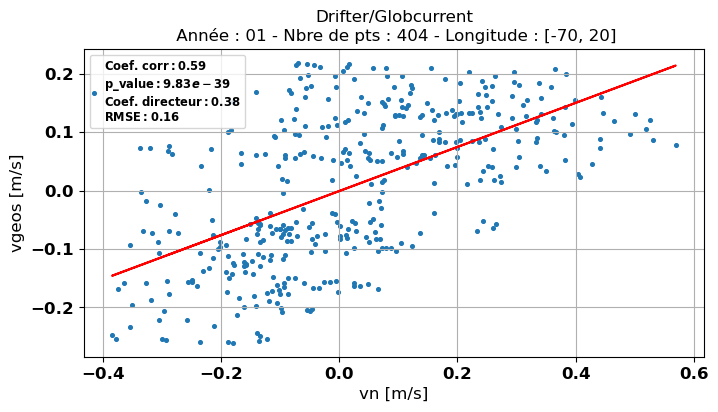

In [16]:
# According to the following, we can simply note that the correlation between "ve" and "ugosa_interpolate" is 0.82. 
# This means that there is a positive and strong relationship  between this two variables.
# Calcul de la corrélation spatiale et temporelle Pearson
correlation, p_value = pearsonr(bouees_courant_v, satellitaires_courant_2)

print("Corrélation de Pearson:", correlation)
print("Valeur de p (p-value):", p_value)

# Fit linear regression model

slope, intercept, _, _, _ = linregress( bouees_courant_v,satellitaires_courant_2)

# Calcul de la régression linéaire
coefficients = np.polyfit(bouees_courant_v, satellitaires_courant_2, 1)
p = np.poly1d(coefficients) # p = 0.38

# Calcul de l'erreur quadratique moyenne (RMSE)
rmse = np.sqrt(np.mean((bouees_courant_v - satellitaires_courant_2)**2)) # r = 0.16

# Plot data and linear regression line
plt.figure(figsize=(8, 4))
plt.scatter(bouees_courant_v,satellitaires_courant_2, s=7)
plt.plot(bouees_courant_v, slope*bouees_courant_v + intercept, color='red', label='Linear Regression')
plt.xlabel('vn [m/s]')
plt.ylabel('vgeos [m/s]')

# Légende
legend_text = (
    r'$\text{Coef. corr} : 0.59$' + '\n'
    r'$\text{p_value} : 9.83e-39$' + '\n'
    r'$\text{Coef. directeur} : 0.38$' + '\n'
    r'$\text{RMSE} : 0.16$'
)

# Affichage de la légende
plt.legend([legend_text], title='', fontsize='x-small', title_fontsize='x-small', handlelength=0, loc="upper left")

# Titre
title_text = 'Drifter/Globcurrent\n Année : 01 - Nbre de pts : 404 - Longitude : [-70, 20]'
plt.title(title_text, fontsize=12)
plt.grid(True)

# Set font size and font weight for tick labels
plt.rcParams['font.size'] = 12
plt.rcParams['font.weight'] = 'bold'
plt.savefig("fig12 mode.png")
plt.show()

## Using Time Series

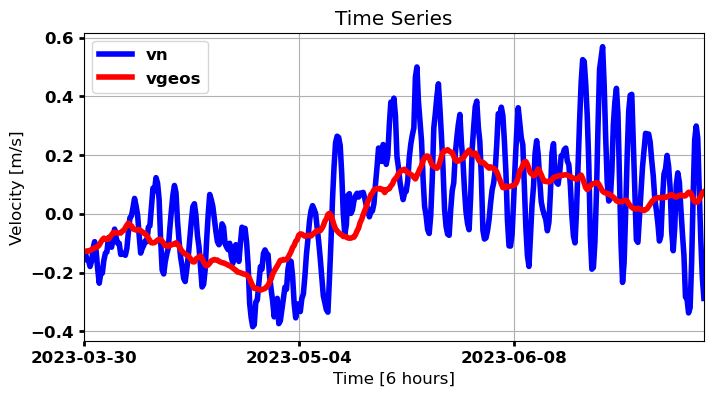

In [17]:
 # Plot time series
plt.figure(figsize=(8, 4))
plt.plot(df_2['time'], bouees_courant_v, color='Blue', label='vn', linewidth=4)
plt.plot(df_2['time'], satellitaires_courant_2, color='RED', label='vgeos', linewidth=4)
plt.legend([f'Correlation: {correlation:.2f}'], loc='upper left')

# Add title, axis labels, grid and legend 
plt.title('Time Series')
plt.xlabel('Time [6 hours]')
plt.ylabel('Velocity [m/s]')
plt.grid(True)
plt.legend()
# Set font size and font weight directly on the Axes object
ax = plt.gca()
ax.tick_params(axis='both', which='major', labelsize=12, width=2)
for label in ax.get_xticklabels():
    label.set_fontweight('bold')

# Set x-axis limits and tick labels
ax.set_xlim(pd.Timestamp('2023-03-30'), pd.Timestamp('2023-07-09'))
ax.set_xticks(pd.date_range(start='2023-03-30', end='2023-07-09', freq='840H'))
ax.set_xticklabels(pd.date_range(start='2023-03-30', end='2023-07-09', freq='840H').strftime('%Y-%m-%d'), rotation=0)

plt.savefig("fig13 mode.png")
plt.show()

# Summarize

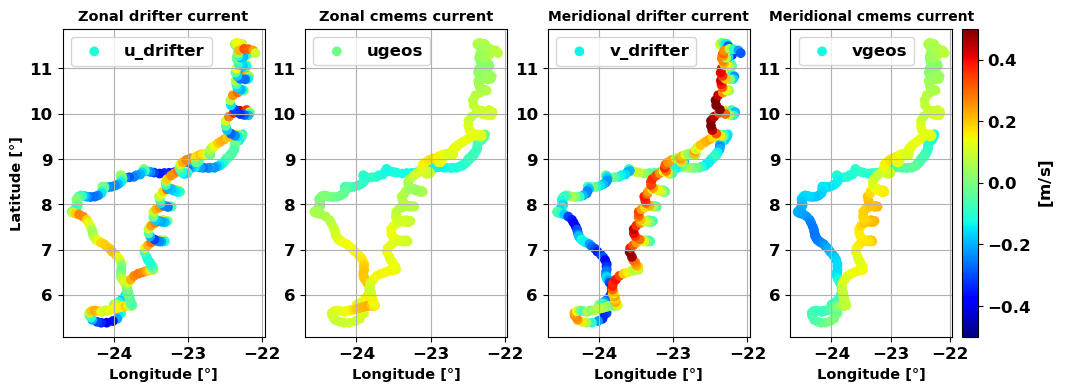

In [18]:
# Création du graphique avec trois sous-graphiques sur une ligne
plt.figure(figsize=(12, 4))

plt.subplot(1, 4, 1)  # Premier sous-graphique
plt.scatter(df_2['longitude'], df_2['latitude'], c= df_2['ve'],vmin=-0.5, vmax=0.5, cmap='jet', marker='o')

# Add title, axis labels, grid and legend
plt.title('Zonal drifter current', fontsize=10.5, fontweight='bold')
plt.xlabel('Longitude [°]', fontsize=10.5, fontweight='bold')
plt.ylabel('Latitude [°]', fontsize=10.5, fontweight='bold')
plt.grid(True)
plt.legend(['u_drifter'])

plt.subplot(1, 4, 2)  # Deuxième sous-graphique

plt.scatter(df_2['longitude'], df_2['latitude'], c= satellitaires_courant_1,vmin=-0.5, vmax=0.5, cmap='jet', marker='o')

# Add title, axis labels, grid and colorbar
plt.title('Zonal cmems current', fontsize=10.5, fontweight='bold')
plt.xlabel('Longitude [°]', fontsize=10.5, fontweight='bold')
plt.grid(True)
plt.legend(['ugeos'])

plt.subplot(1, 4, 3)  # Troisième sous-graphique

plt.scatter(df_2['longitude'], df_2['latitude'], c= df_2['vn'],vmin=-0.5, vmax=0.5, cmap='jet', marker='o')

# Add title, axis labels, grid and legend
plt.title('Meridional drifter current', fontsize=10, fontweight='bold')
plt.xlabel('Longitude [°]', fontsize=10.5, fontweight='bold')
plt.grid(True)
plt.legend(['v_drifter'])

plt.subplot(1, 4, 4) # Quatrième sous-graphique
plt.scatter(df_2['longitude'], df_2['latitude'], c= satellitaires_courant_2,vmin=-0.5, vmax=0.5, cmap='jet', marker='o')

# Add title, axis labels, grid and colorbar
plt.title('Meridional cmems current', fontsize=10, fontweight='bold')
plt.xlabel('Longitude [°]', fontsize=10.5, fontweight='bold')
plt.grid(True)
plt.legend(['vgeos'])

plt.colorbar(label=r'$\mathbf{[m/s]}$')
plt.savefig("fig14 mode.png")

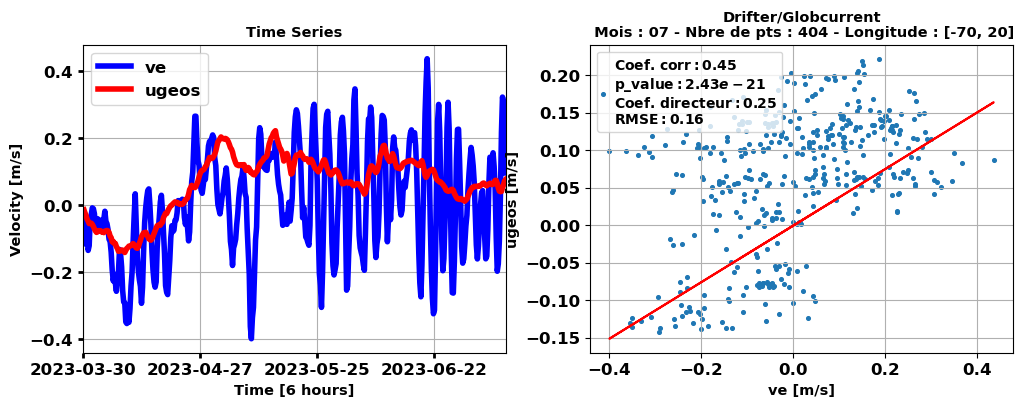

In [19]:
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)  # Premier sous-graphique
plt.plot(df_2['time'], bouees_courant_u, color='Blue', label='ve', linewidth=4)
plt.plot(df_2['time'], satellitaires_courant_1, color='RED', label='ugeos', linewidth=4)
plt.legend([f'Correlation: {correlation:.2f}'], loc='upper left')

# Add title, axis labels, grid and legend 
plt.title('Time Series', fontsize=10.5, fontweight='bold')
plt.xlabel('Time [6 hours]', fontsize=10.5, fontweight='bold')
plt.ylabel('Velocity [m/s]', fontsize=10.5, fontweight='bold')
plt.grid(True)
plt.legend()
# Set font size and font weight directly on the Axes object
ax = plt.gca()
ax.tick_params(axis='both', which='major', labelsize=12, width=2)
for label in ax.get_xticklabels():
    label.set_fontweight('bold')

# Set x-axis limits and tick labels
ax.set_xlim(pd.Timestamp('2023-03-30'), pd.Timestamp('2023-07-09'))
ax.set_xticks(pd.date_range(start='2023-03-30', end='2023-07-09', freq='672H'))
ax.set_xticklabels(pd.date_range(start='2023-03-30', end='2023-07-09', freq='672H').strftime('%Y-%m-%d'), rotation=0)

plt.subplot(1, 2, 2)  # Deuxième sous-graphique
plt.scatter(bouees_courant_u,satellitaires_courant_1, s=7)
plt.plot(bouees_courant_u, slope*bouees_courant_u + intercept, color='red', label='Linear Regression')
plt.xlabel('ve [m/s]', fontsize=10.5, fontweight='bold')
plt.ylabel('ugeos [m/s]', fontsize=10.5, fontweight='bold')

# Légende
legend_text = (
    r'$\text{Coef. corr} : 0.45$' + '\n'
    r'$\text{p_value} : 2.43e-21$' + '\n'
    r'$\text{Coef. directeur} : 0.25$' + '\n'
    r'$\text{RMSE} : 0.16$'
)

# Affichage de la légende
plt.legend([legend_text], title='', fontsize='small', title_fontsize='small', handlelength=0, loc="upper left")

# Titre
title_text = 'Drifter/Globcurrent\n Mois : 07 - Nbre de pts : 404 - Longitude : [-70, 20]'
plt.title(title_text, fontsize=10.5, fontweight='bold')
plt.grid(True)
plt.savefig("fig15 mode.png")

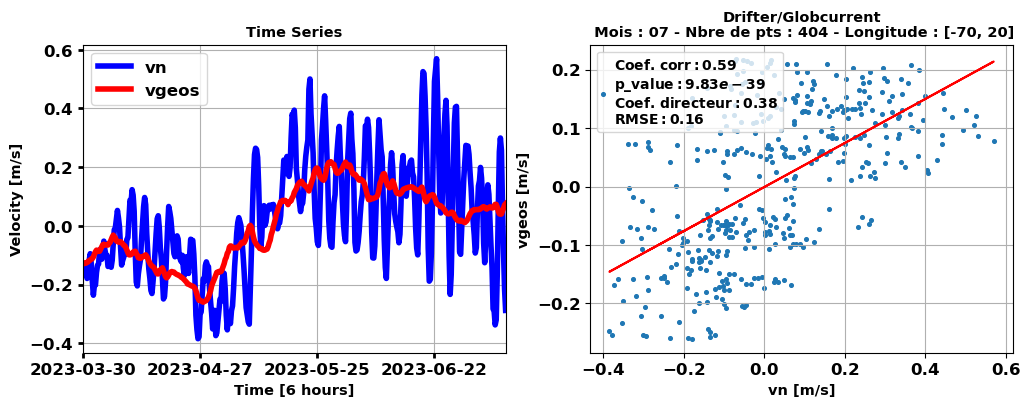

In [20]:
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)  # Premier sous-graphique
plt.plot(df_2['time'], bouees_courant_v, color='Blue', label='vn', linewidth=4)
plt.plot(df_2['time'], satellitaires_courant_2, color='RED', label='vgeos', linewidth=4)
plt.legend([f'Correlation: {correlation:.2f}'], loc='upper left')

# Add title, axis labels, grid and legend 
plt.title('Time Series', fontsize=10.5, fontweight='bold')
plt.xlabel('Time [6 hours]', fontsize=10.5, fontweight='bold')
plt.ylabel('Velocity [m/s]', fontsize=10.5, fontweight='bold')
plt.grid(True)
plt.legend()
# Set font size and font weight directly on the Axes object
ax = plt.gca()
ax.tick_params(axis='both', which='major', labelsize=12, width=2)
for label in ax.get_xticklabels():
    label.set_fontweight('bold')

# Set x-axis limits and tick labels
ax.set_xlim(pd.Timestamp('2023-03-30'), pd.Timestamp('2023-07-09'))
ax.set_xticks(pd.date_range(start='2023-03-30', end='2023-07-09', freq='672H'))
ax.set_xticklabels(pd.date_range(start='2023-03-30', end='2023-07-09', freq='672H').strftime('%Y-%m-%d'), rotation=0)

plt.subplot(1, 2, 2)  # Deuxième sous-graphique
plt.scatter(bouees_courant_v,satellitaires_courant_2, s=7)
plt.plot(bouees_courant_v, slope*bouees_courant_v + intercept, color='red', label='Linear Regression')
plt.xlabel('vn [m/s]', fontsize=10.5, fontweight='bold')
plt.ylabel('vgeos [m/s]', fontsize=10.5, fontweight='bold')

# Légende
legend_text = (
    r'$\text{Coef. corr} : 0.59$' + '\n'
    r'$\text{p_value} : 9.83e-39$' + '\n'
    r'$\text{Coef. directeur} : 0.38$' + '\n'
    r'$\text{RMSE} : 0.16$'
)

# Affichage de la légende
plt.legend([legend_text], title='', fontsize='small', title_fontsize='small', handlelength=0, loc="upper left")

# Titre
title_text = 'Drifter/Globcurrent\n Mois : 07 - Nbre de pts : 404 - Longitude : [-70, 20]'
plt.title(title_text, fontsize=10.5, fontweight='bold')
plt.grid(True)
plt.savefig("fig16 mode.png")

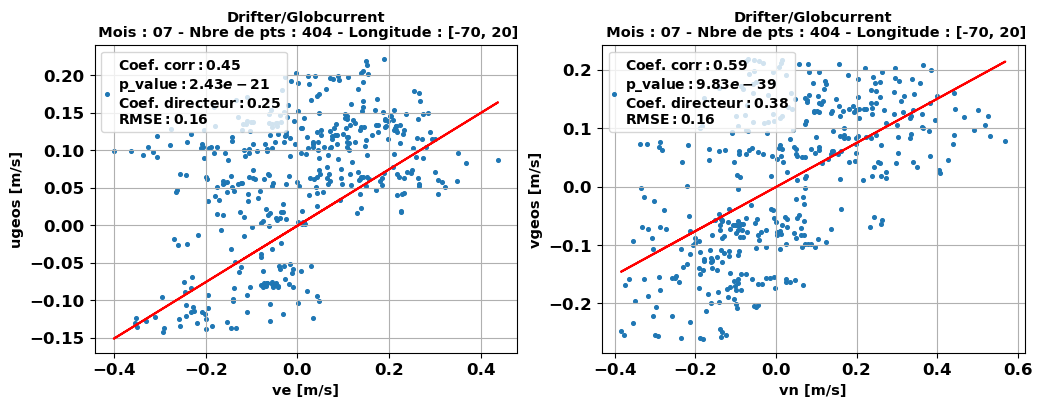

In [21]:
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)  # Premier sous-graphique
plt.scatter(bouees_courant_u,satellitaires_courant_1, s=7)
plt.plot(bouees_courant_u, slope*bouees_courant_u + intercept, color='red', label='Linear Regression')
plt.xlabel('ve [m/s]', fontsize=10.5, fontweight='bold')
plt.ylabel('ugeos [m/s]', fontsize=10.5, fontweight='bold')

# Légende
legend_text = (
    r'$\text{Coef. corr} : 0.45$' + '\n'
    r'$\text{p_value} : 2.43e-21$' + '\n'
    r'$\text{Coef. directeur} : 0.25$' + '\n'
    r'$\text{RMSE} : 0.16$'
)

# Affichage de la légende
plt.legend([legend_text], title='', fontsize='small', title_fontsize='small', handlelength=0, loc="upper left")

# Titre
title_text = 'Drifter/Globcurrent\n Mois : 07 - Nbre de pts : 404 - Longitude : [-70, 20]'
plt.title(title_text, fontsize=10.5, fontweight='bold')
plt.grid(True)

plt.subplot(1, 2, 2)  # Premier sous-graphique

plt.scatter(bouees_courant_v,satellitaires_courant_2, s=7)
plt.plot(bouees_courant_v, slope*bouees_courant_v + intercept, color='red', label='Linear Regression')
plt.xlabel('vn [m/s]', fontsize=10.5, fontweight='bold')
plt.ylabel('vgeos [m/s]', fontsize=10.5, fontweight='bold')

# Légende
legend_text = (
    r'$\text{Coef. corr} : 0.59$' + '\n'
    r'$\text{p_value} : 9.83e-39$' + '\n'
    r'$\text{Coef. directeur} : 0.38$' + '\n'
    r'$\text{RMSE} : 0.16$'
)

# Affichage de la légende
plt.legend([legend_text], title='', fontsize='small', title_fontsize='small', handlelength=0, loc="upper left")

# Titre
title_text = 'Drifter/Globcurrent\n Mois : 07 - Nbre de pts : 404 - Longitude : [-70, 20]'
plt.title(title_text, fontsize=10.5, fontweight='bold')
plt.grid(True)
plt.savefig("fig17 mode.png")

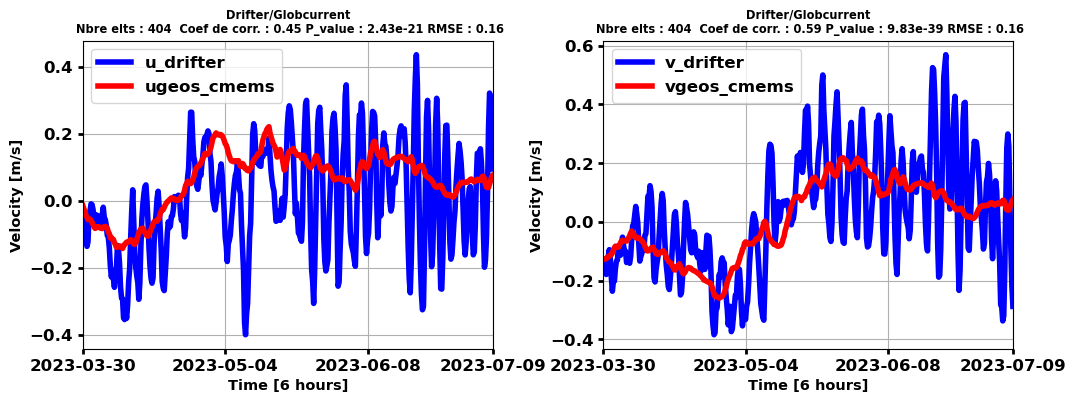

In [22]:
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)  # Premier sous-graphique
plt.plot(df_2['time'], bouees_courant_u, color='Blue', label='u_drifter', linewidth=4)
plt.plot(df_2['time'], satellitaires_courant_1, color='RED', label='ugeos_cmems', linewidth=4)
plt.legend([f'Correlation: {correlation:.2f}'], loc='upper left')

# Add title, axis labels, grid and legend 
plt.title('Time Series', fontsize=10.5, fontweight='bold')
plt.xlabel('Time [6 hours]', fontsize=10.5, fontweight='bold')
plt.ylabel('Velocity [m/s]', fontsize=10.5, fontweight='bold')
plt.grid(True)
plt.legend()

# Configurer l'axe x
ax = plt.gca()
# Définir les limites de l'axe x en utilisant les dates min et max du DataFrame
min_date = df_2['time'].min()
max_date = df_2['time'].max()
ax.set_xlim(min_date, max_date)

# Ajouter les ticks de l'axe x avec une fréquence de 840 heures (35 jours)
# Assurez-vous que les ticks couvrent toute la période des données
xticks = pd.date_range(start=min_date, end=max_date, freq='840H')
if xticks[-1] < max_date:  # Vérifier si la dernière tick est avant la date de fin
    xticks = xticks.append(pd.DatetimeIndex([max_date]))

ax.set_xticks(xticks)
ax.set_xticklabels(xticks.strftime('%Y-%m-%d'), rotation=0)

# Ajuster les paramètres de la police
ax.tick_params(axis='both', which='major', labelsize=12, width=2)
for label in ax.get_xticklabels():
    label.set_fontweight('bold')

# Titre
title_text = 'Drifter/Globcurrent\n Nbre elts : 404  Coef de corr. : 0.45 P_value : 2.43e-21 RMSE : 0.16'
plt.title(title_text, fontsize=8.2, fontweight='bold')

plt.subplot(1, 2, 2)  # Premier sous-graphique
 
plt.plot(df_2['time'], bouees_courant_v, color='Blue', label='v_drifter', linewidth=4)
plt.plot(df_2['time'], satellitaires_courant_2, color='RED', label='vgeos_cmems', linewidth=4)
plt.legend([f'Correlation: {correlation:.2f}'], loc='upper left')

# Add title, axis labels, grid and legend 
plt.title('Time Series', fontsize=10.5, fontweight='bold')
plt.xlabel('Time [6 hours]', fontsize=10.5, fontweight='bold')
plt.ylabel('Velocity [m/s]', fontsize=10.5, fontweight='bold')
plt.grid(True)
plt.legend()

# Configurer l'axe x
ax = plt.gca()
# Définir les limites de l'axe x en utilisant les dates min et max du DataFrame
min_date = df_2['time'].min()
max_date = df_2['time'].max()
ax.set_xlim(min_date, max_date)

# Ajouter les ticks de l'axe x avec une fréquence de 840 heures (35 jours)
# Assurez-vous que les ticks couvrent toute la période des données
xticks = pd.date_range(start=min_date, end=max_date, freq='840H')
if xticks[-1] < max_date:  # Vérifier si la dernière tick est avant la date de fin
    xticks = xticks.append(pd.DatetimeIndex([max_date]))

ax.set_xticks(xticks)
ax.set_xticklabels(xticks.strftime('%Y-%m-%d'), rotation=0)

# Ajuster les paramètres de la police
ax.tick_params(axis='both', which='major', labelsize=12, width=2)
for label in ax.get_xticklabels():
    label.set_fontweight('bold')

# Titre
title_text = 'Drifter/Globcurrent\n Nbre elts : 404  Coef de corr. : 0.59 P_value : 9.83e-39 RMSE : 0.16'
plt.title(title_text, fontsize=8.2, fontweight='bold')
plt.subplots_adjust( wspace=0.27)  # Ajuster hspace et wspace si nécessaire

plt.savefig("fig18 mode.png")

## Conclusion
 - Strong relationship between the variables ugeos (CMEMS Current) and u_drifter (Drifter Current).
 - Strong relationship  between vgeos (CMEMS Current) and v_drifter (Drifter Current).
 - Zonal component slightly dominated by the meridional component.
 - Altimetric current measurements are better and can be improved by considering certain components, notably Ekman and inertial components.